# Overall Classification

3 different classification tasks:
* Ecoli
* Coliform
* Ecoli + Coliform

Classes are defined through thresholds

# BEAR IN MIND

* **Precision**: How many of our predictions are correct? Precision is the ability of a classifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”

* **Recall**: How well do you notice the phenomenon? Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”

* **F1 score**: The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

* **Support**: Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
data_path = os.path.join("..", "..", "data")

dir_store_path = os.path.join(data_path, "temporary results")

full_dataset_path = os.path.join(dir_store_path, "overall_dataset.xlsx")

# Load Data

In [43]:
full_df = pd.read_excel(full_dataset_path)

In [44]:
full_df.columns.to_list()

['DateTime',
 'Site',
 'Technician Water Quality',
 'Technician Counting',
 'Temp C_mean',
 'Temp C_std',
 'Ph_mean',
 'Ph_std',
 'Cond (ms)_mean',
 'Cond (ms)_std',
 'Coliform (1ml)_mean',
 'Coliform (1ml)_std',
 'Ecoli (1ml)_mean',
 'Ecoli (1ml)_std',
 'cso_hinterland',
 'cso_middle',
 'cso_sea',
 'rained',
 'mean_rainfall',
 'tide_value',
 'bacteria_sum']

In [45]:
full_df = full_df[full_df["DateTime"] > "2023-05-01"]

In [46]:
full_df = full_df.drop(
    columns=[
        "Site",
        "Technician Water Quality",
        "Technician Counting",
        "Temp C_std",
        "Ph_std",
        "Cond (ms)_std",
        "Coliform (1ml)_std",
        "Ecoli (1ml)_std",
    ]
)

# Bacteria Sum

In [47]:
bacteria_df = full_df.drop(columns=["Ecoli (1ml)_mean", "Coliform (1ml)_mean"])

<Axes: xlabel='bacteria_sum', ylabel='Count'>

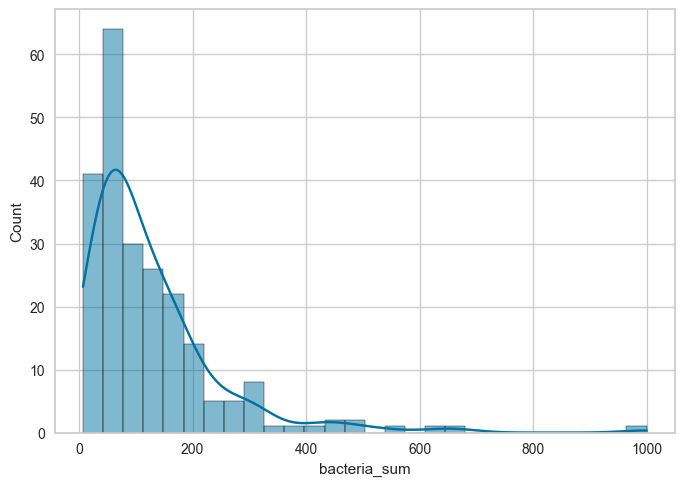

In [48]:
sns.histplot(bacteria_df["bacteria_sum"], kde=True)

In [49]:
# scale to log scale
bacteria_df["bacteria_sum"] = np.log10(bacteria_df["bacteria_sum"])

<Axes: xlabel='bacteria_sum', ylabel='Count'>

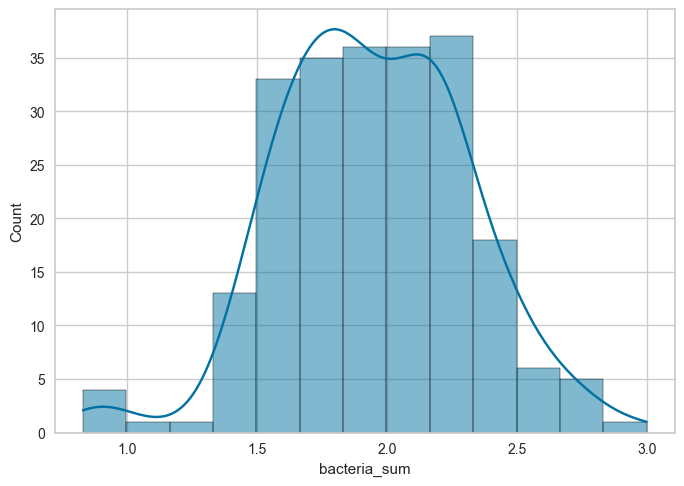

In [50]:
sns.histplot(bacteria_df["bacteria_sum"], kde=True)

## Define classes

In [51]:
# define function to classify ecoli levels based on quartiles
def ecoli_level(value):
    if value <= bacteria_df["bacteria_sum"].quantile(0.5):
        return "Low"
    else:
        return "High"

In [52]:
# define classes for Ecoli based on quantiles
bacteria_df["Class"] = bacteria_df["bacteria_sum"].apply(ecoli_level)

bacteria_df.drop(columns=["bacteria_sum"], inplace=True)

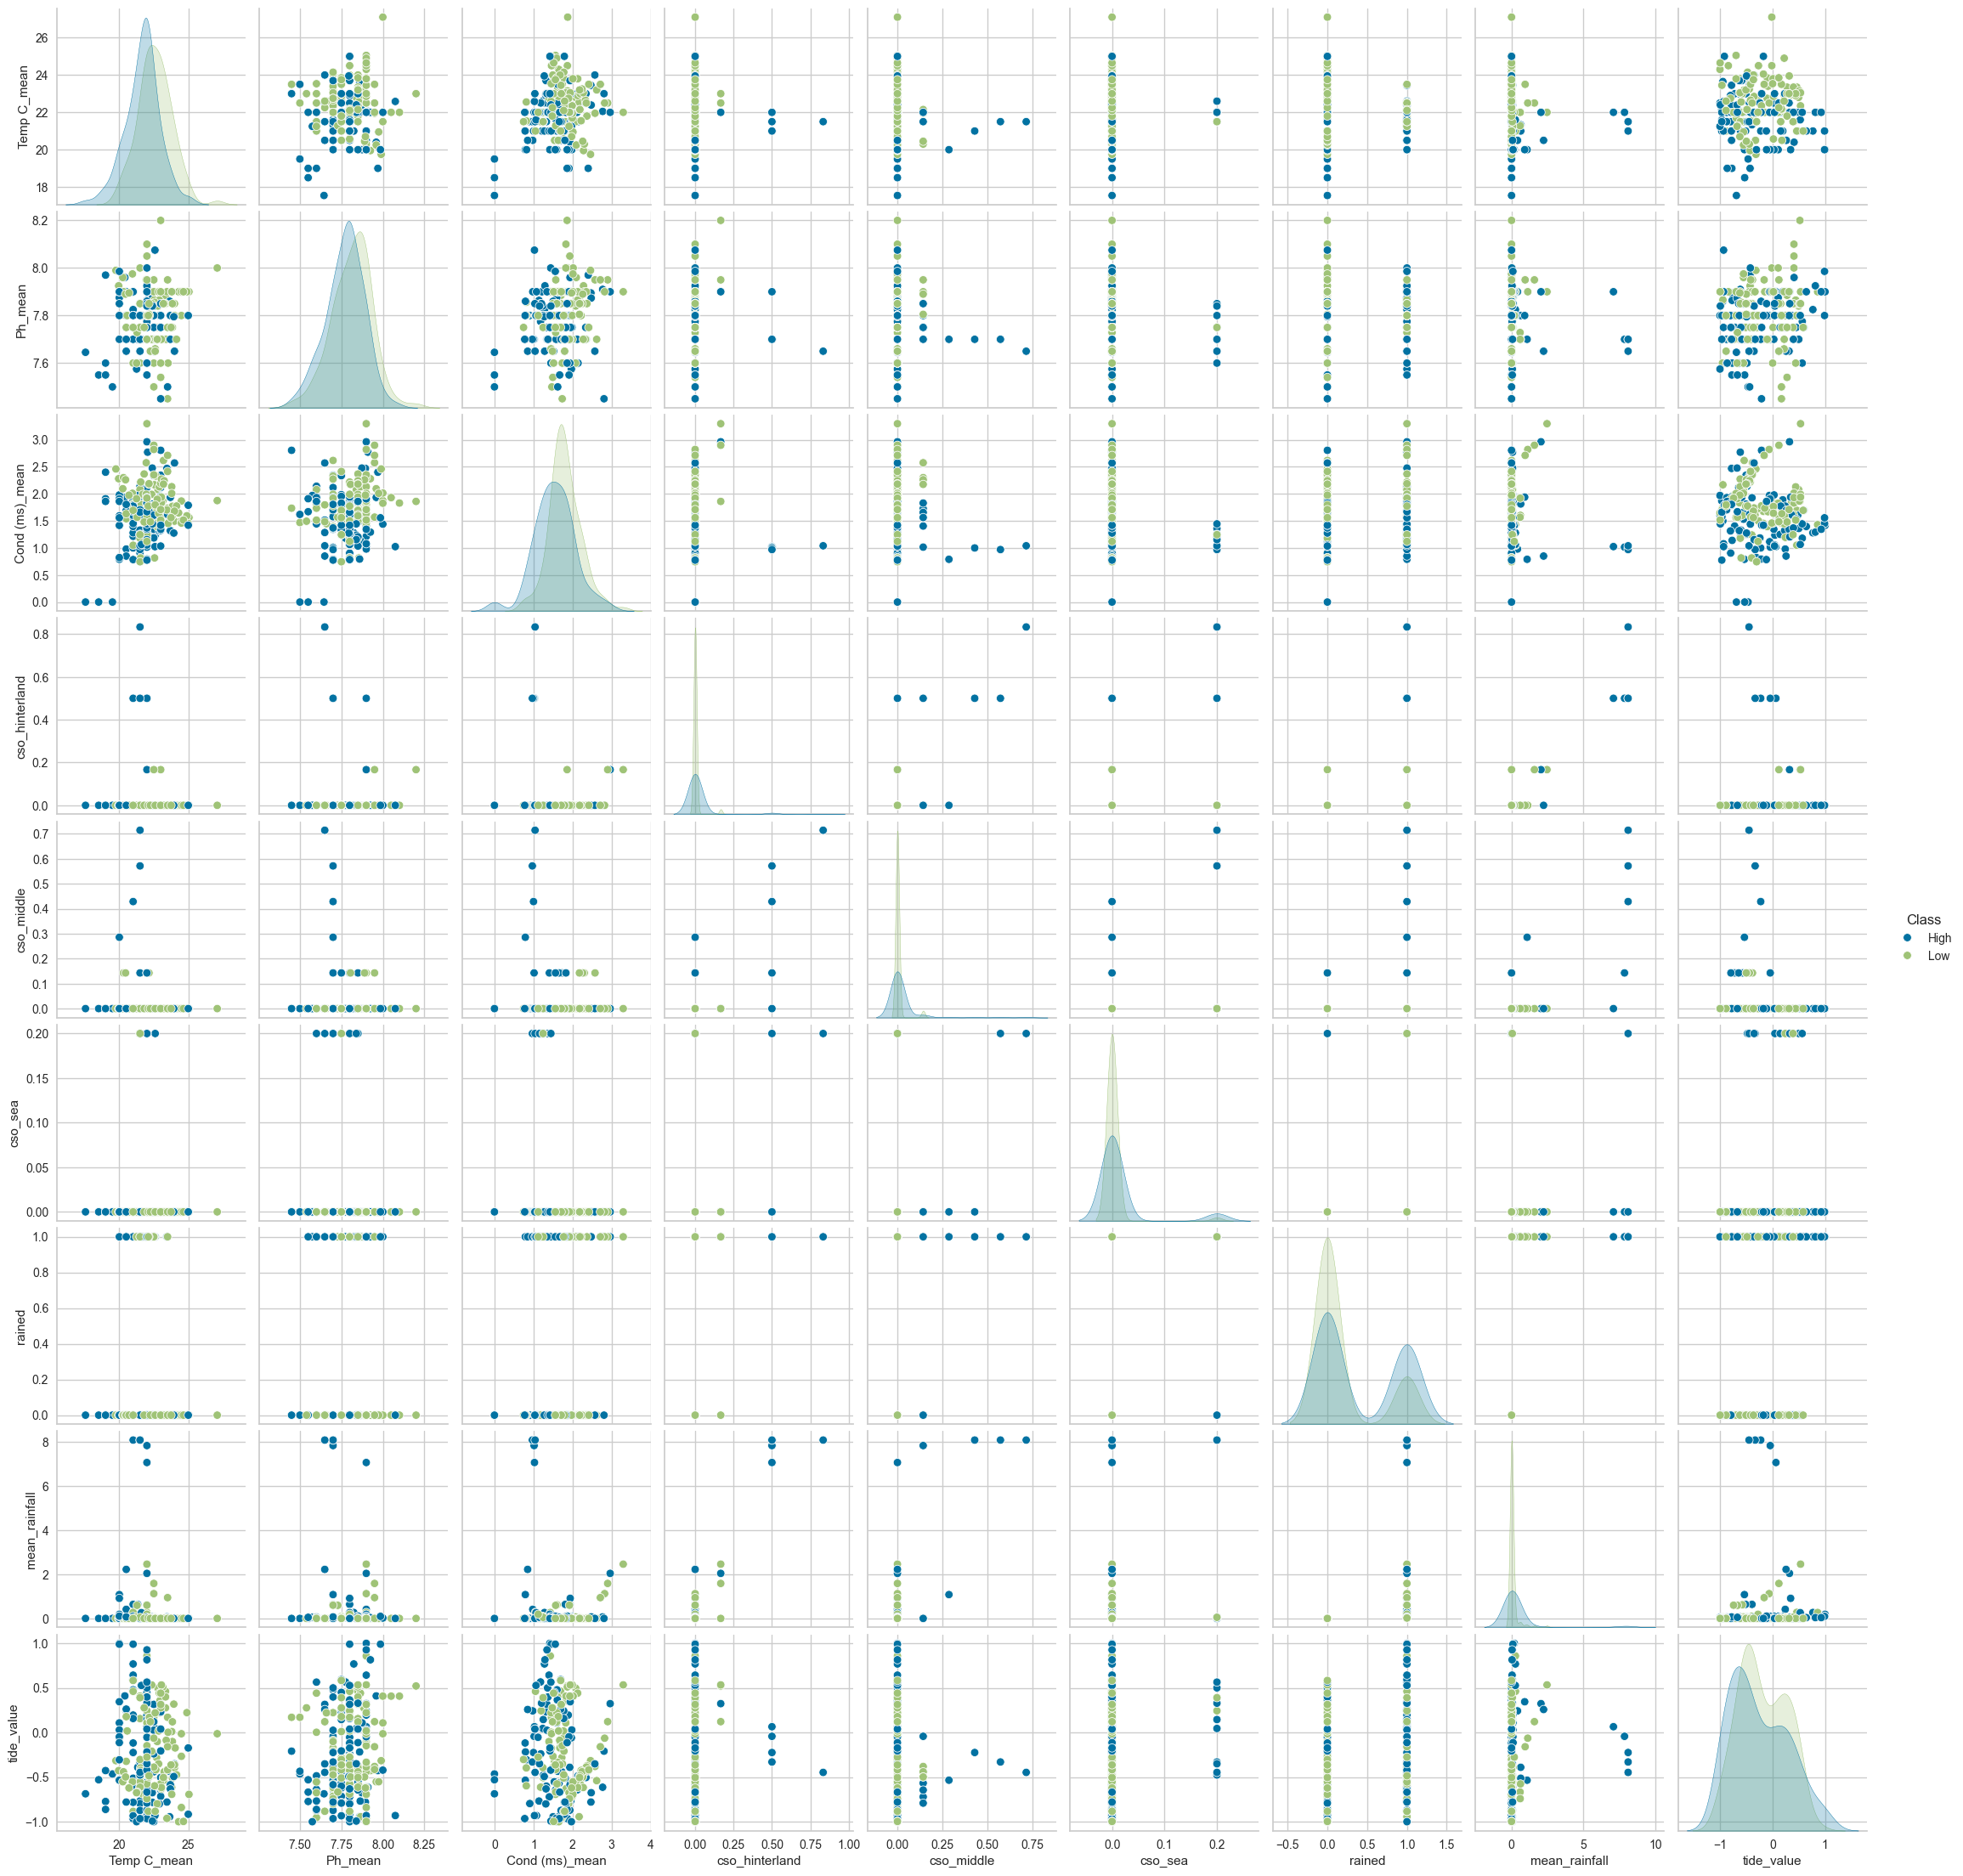

In [53]:
sns.pairplot(bacteria_df, hue="Class")

In [54]:
# count number of samples in each class
bacteria_df["Class"].value_counts()

Class
High    113
Low     113
Name: count, dtype: int64

# Perform Classification

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

In [56]:
bacteria_df.isna().sum()

DateTime          0
Temp C_mean       0
Ph_mean           0
Cond (ms)_mean    0
cso_hinterland    0
cso_middle        0
cso_sea           0
rained            0
mean_rainfall     0
tide_value        0
Class             0
dtype: int64

In [57]:
X = bacteria_df.drop(
    columns=[
        "DateTime",
        "Class",
    ]
).copy()
y = bacteria_df["Class"].copy()

y = y.map({"Low": 0, "High": 1})

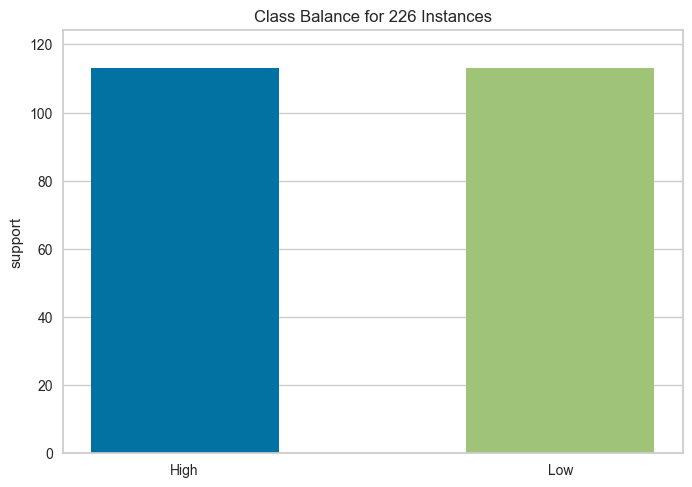

<Axes: title={'center': 'Class Balance for 226 Instances'}, ylabel='support'>

In [58]:
from yellowbrick.classifier import (
    ClassificationReport,
    ROCAUC,
    ClassPredictionError,
    ConfusionMatrix,
    PrecisionRecallCurve,
    ClassBalance,
)


classes = bacteria_df["Class"].unique()

visualizer = ClassBalance(labels=classes)
visualizer.fit(y)
visualizer.show()

# Feature Selection

In [59]:
import warnings
from sklearn import model_selection
from sklearn.feature_selection import SequentialFeatureSelector

selected_features = []

models = [
    LogisticRegression(),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(),
    LinearSVC(),
    SGDClassifier(),
    xgb.XGBClassifier(),
]

warnings.filterwarnings("ignore")

for model in models:
    print("=" * 80)
    print(model)
    print("=" * 80)
    print()

    cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

    for direction in ["forward", "backward"]:
        print("Direction:", direction)
        print()
        sfs = SequentialFeatureSelector(
            model, n_features_to_select="auto", direction=direction, cv=cv
        )
        sfs.fit(X, y)
        print(X.columns[sfs.get_support()])
        print("-" * 10)

        selected_features.append(X.columns[sfs.get_support()].to_list())


# get the most common features
from collections import Counter

selected_features = Counter(
    [feature for sublist in selected_features for feature in sublist]
)

LogisticRegression()

Direction: forward

Index(['Temp C_mean', 'Cond (ms)_mean', 'cso_middle', 'tide_value'], dtype='object')
----------
Direction: backward

Index(['Temp C_mean', 'Cond (ms)_mean', 'cso_sea', 'mean_rainfall',
       'tide_value'],
      dtype='object')
----------
RandomForestClassifier()

Direction: forward

Index(['Temp C_mean', 'Ph_mean', 'cso_sea', 'mean_rainfall'], dtype='object')
----------
Direction: backward

Index(['Temp C_mean', 'Ph_mean', 'Cond (ms)_mean', 'cso_sea', 'mean_rainfall'], dtype='object')
----------
DecisionTreeClassifier()

Direction: forward

Index(['Temp C_mean', 'Ph_mean', 'cso_hinterland', 'cso_sea'], dtype='object')
----------
Direction: backward

Index(['Temp C_mean', 'Ph_mean', 'cso_hinterland', 'rained', 'mean_rainfall'], dtype='object')
----------
KNeighborsClassifier()

Direction: forward

Index(['Temp C_mean', 'Ph_mean', 'cso_hinterland', 'mean_rainfall'], dtype='object')
----------
Direction: backward

Index(['Temp C_mean', 'Ph_mean'

In [60]:
selected_features

Counter({'Temp C_mean': 12,
         'Cond (ms)_mean': 12,
         'tide_value': 11,
         'Ph_mean': 10,
         'mean_rainfall': 9,
         'cso_hinterland': 8,
         'cso_middle': 7,
         'rained': 7,
         'cso_sea': 5})

In [61]:
%%script false --no-raise-error
# Comment this line to keep all features

# Drop the features that are not selected at least half of the times

X.drop(
    columns=[
        "Cond (ms)_mean",
        "Ph_mean",
        "cso_hinterland",
        "cso_middle",
    ],
    inplace=True,
)

# Model Selection

In [62]:
import optuna

In [63]:
from sklearn import model_selection


def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier",
        [
            "RandomForest",
            "XGBoost",
            "LogisticRegression",
            "SVC",
            "KNN",
            "DecisionTree",
            "GaussianNB",
            "LinearSVC",
            "SGDClassifier",
        ],
    )

    if classifier_name == "RandomForest":
        model = RandomForestClassifier(
            random_state=42,
        )

    elif classifier_name == "XGBoost":
        model = xgb.XGBClassifier(
            random_state=42,
        )

    elif classifier_name == "LogisticRegression":
        model = LogisticRegression(
            random_state=42,
        )

    elif classifier_name == "SVC":
        model = SVC(
            random_state=42,
        )

    elif classifier_name == "KNN":
        model = KNeighborsClassifier()

    elif classifier_name == "DecisionTree":
        model = DecisionTreeClassifier(
            random_state=42,
        )

    elif classifier_name == "GaussianNB":
        model = GaussianNB()

    elif classifier_name == "LinearSVC":
        model = LinearSVC(
            random_state=42,
        )

    elif classifier_name == "SGDClassifier":
        model = SGDClassifier(
            random_state=42,
        )

    else:
        raise ValueError("Invalid classifier name")

    cv = model_selection.KFold(n_splits=20, shuffle=True, random_state=42)
    results = model_selection.cross_val_score(
        estimator=model, X=X, y=y, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [64]:
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///bacteria.sqlite3",
    study_name="Model Selection - Bacteria - Overall - After May",
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-06 10:50:03,751] A new study created in RDB with name: Model Selection - Bacteria - Overall - After May


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-06 10:50:03,906] Trial 0 finished with value: 0.6872613143936672 and parameters: {'classifier': 'LogisticRegression'}. Best is trial 0 with value: 0.6872613143936672.
[I 2024-03-06 10:50:18,960] Trial 1 finished with value: 0.699134931653314 and parameters: {'classifier': 'XGBoost'}. Best is trial 1 with value: 0.699134931653314.
[I 2024-03-06 10:50:19,025] Trial 2 finished with value: 0.5800339937839938 and parameters: {'classifier': 'SVC'}. Best is trial 1 with value: 0.699134931653314.
[I 2024-03-06 10:50:19,081] Trial 3 finished with value: 0.5204903103432514 and parameters: {'classifier': 'SGDClassifier'}. Best is trial 1 with value: 0.699134931653314.
[I 2024-03-06 10:50:19,137] Trial 4 finished with value: 0.6606018287268287 and parameters: {'classifier': 'DecisionTree'}. Best is trial 1 with value: 0.699134931653314.
[I 2024-03-06 10:50:19,188] Trial 5 finished with value: 0.6606018287268287 and parameters: {'classifier': 'DecisionTree'}. Best is trial 1 with value: 

Since the Condunctivity should be proportional with the tide_value, remove the cond.

Leave just mean_rainfall, tide_value, Temp, rained and cso_sea

In [65]:
study.best_params

{'classifier': 'RandomForest'}

# Hyperparameter Tuning

In [66]:
from sklearn import model_selection


def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier", ["RandomForest", "XGBoost", "KNN"]
    )

    if classifier_name == "RandomForest":
        n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
        max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
        max_features = trial.suggest_categorical(
            "max_features", ["auto", "sqrt", "log2"]
        )
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            criterion=criterion,
            random_state=42,
        )

    elif classifier_name == "XGBoost":
        n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
        max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
        learning_rate = trial.suggest_float(
            "learning_rate", 0.01, 0.1, log=True
        )
        subsample = trial.suggest_float("subsample", 0.1, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
        model = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
        )

    elif classifier_name == "KNN":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 100)
        weights = trial.suggest_categorical("weights", ["uniform", "distance"])
        algorithm = trial.suggest_categorical(
            "algorithm", ["auto", "ball_tree", "kd_tree", "brute"]
        )
        model = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            algorithm=algorithm,
        )

    else:
        raise ValueError("Invalid classifier name")

    cv = model_selection.KFold(n_splits=20, shuffle=True, random_state=42)
    results = model_selection.cross_val_score(
        estimator=model, X=X, y=y, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [67]:
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///bacteria.sqlite3",
    study_name="Hyperparameter Tuning - Bacteria - Overall - After May",
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-06 10:53:23,224] A new study created in RDB with name: Hyperparameter Tuning - Bacteria - Overall - After May


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-06 10:55:01,052] Trial 0 finished with value: 0.714564844877345 and parameters: {'classifier': 'XGBoost', 'n_estimators': 990, 'max_depth': 36.044049384141395, 'learning_rate': 0.0656208185991728, 'subsample': 0.1790335557250145, 'colsample_bytree': 0.6953853957261267}. Best is trial 0 with value: 0.714564844877345.
[I 2024-03-06 10:55:11,088] Trial 1 finished with value: 0.7330200355200357 and parameters: {'classifier': 'RandomForest', 'n_estimators': 870, 'max_depth': 40.06398433383651, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 1 with value: 0.7330200355200357.
[I 2024-03-06 10:56:37,740] Trial 2 finished with value: 0.7156174034299034 and parameters: {'classifier': 'XGBoost', 'n_estimators': 640, 'max_depth': 51.071870236490305, 'learning_rate': 0.049375471609012705, 'subsample': 0.29939044693433553, 'colsample_bytree': 0.6206272226383583}. Best is trial 1 with value: 0.7330200355200357.
[I 2024-03-06 10:56:47,934] Trial 3 finished with value: 0.73446

In [68]:
study.best_params

{'classifier': 'RandomForest',
 'n_estimators': 750,
 'max_depth': 10.014637480991743,
 'max_features': 'sqrt',
 'criterion': 'gini'}

# Model Evaluation

In [69]:
if study.best_params["classifier"] == "RandomForest":
    model = RandomForestClassifier(
        n_estimators=study.best_params["n_estimators"],
        max_depth=int(study.best_params["max_depth"]),
        max_features=study.best_params["max_features"],
        criterion=study.best_params["criterion"],
        random_state=42,
    )

elif study.best_params["classifier"] == "XGBoost":
    model = xgb.XGBClassifier(
        n_estimators=study.best_params["n_estimators"],
        max_depth=int(study.best_params["max_depth"]),
        learning_rate=study.best_params["learning_rate"],
        subsample=study.best_params["subsample"],
        colsample_bytree=study.best_params["colsample_bytree"],
        random_state=42,
    )

**Warning Note** on inappropriate usage of cross_val_predict

The result of cross_val_predict may be different from those obtained using cross_val_score as the elements are grouped in different ways. The function cross_val_score takes an average over cross-validation folds, whereas cross_val_predict simply returns the labels (or probabilities) from several distinct models undistinguished. Thus, cross_val_predict is not an appropriate measure of generalization error.

In [70]:
cv = model_selection.KFold(n_splits=20, shuffle=True, random_state=42)

# perform cross-validation and store the results
y_pred = model_selection.cross_val_predict(
    model, X, y, cv=cv
)

y_pred_proba = model_selection.cross_val_predict(
    model, X, y, cv=cv, method="predict_proba"
)

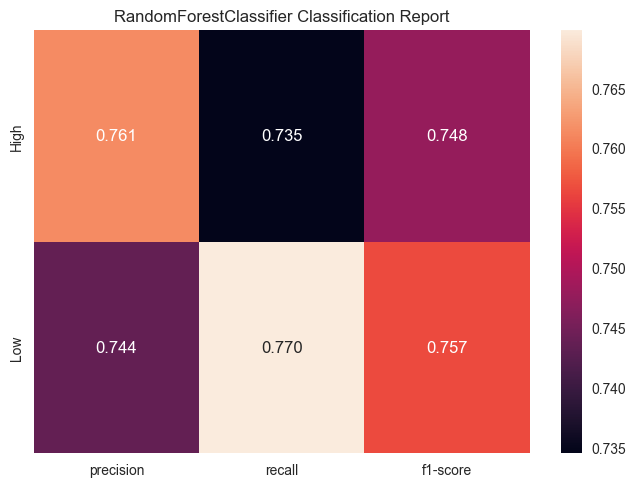

In [71]:
from sklearn.metrics import classification_report


model_name = model.__class__.__name__

report = classification_report(y, y_pred, target_names=classes, output_dict=True)

sns.heatmap(pd.DataFrame(report).iloc[:-1, :-3].T, annot=True, fmt=".3f")

plt.title(f"{model_name} Classification Report")
plt.show()

In [72]:
# accuracy
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy_score(y, y_pred)

0.7522123893805309

In [73]:
f1_score(y, y_pred, average="weighted")

0.7521347434390913

In [74]:
precision_score(y, y_pred, average="weighted")

0.7525288167490002

In [75]:
recall_score(y, y_pred, average="weighted")

0.7522123893805309

In [79]:
from sklearn.metrics import roc_curve, roc_auc_score

roc_auc_score(y, y_pred_proba[:, 1])

0.7860443261022789

<Figure size 1000x1000 with 0 Axes>

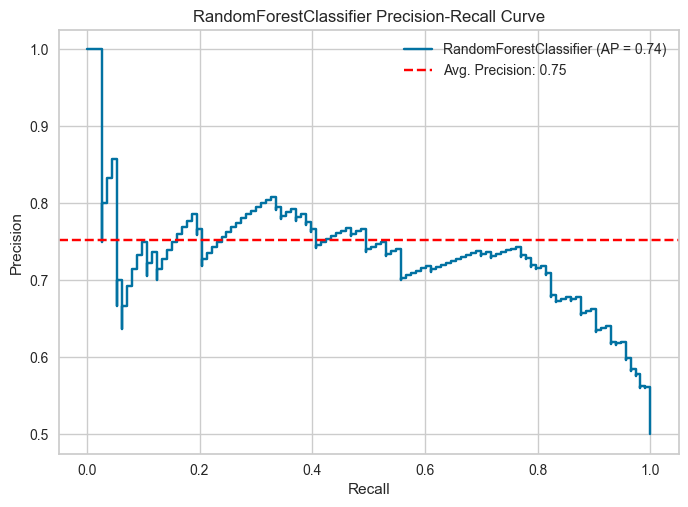

In [76]:
from sklearn.metrics import PrecisionRecallDisplay, precision_score

plt.figure(figsize=(10, 10))
display = PrecisionRecallDisplay.from_predictions(y, y_pred_proba[:, 1], name=f"{model.__class__.__name__}")

# plot avg precision
avg_precision = precision_score(y, y_pred, average="weighted")


plt.axhline(avg_precision, color="red", linestyle="--", label=f"Avg. Precision: {avg_precision:.2f}")

plt.setp(plt.gca(), xlabel="Recall", ylabel="Precision")

plt.title(f"{model.__class__.__name__} Precision-Recall Curve")

plt.legend()

plt.show()


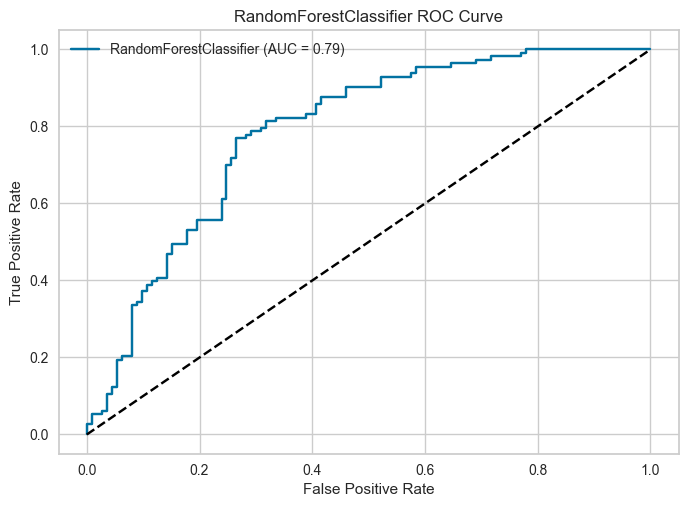

In [77]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_predictions(y, y_pred_proba[:, 1], pos_label=1, name=f"{model_name}")

sns.lineplot(
    x=[0, 1],
    y=[0, 1],
    color="black",
    linestyle="--",
)

plt.setp(plt.gca(), xlabel="False Positive Rate", ylabel="True Positive Rate")

plt.title(f"{model.__class__.__name__} ROC Curve")

plt.show()

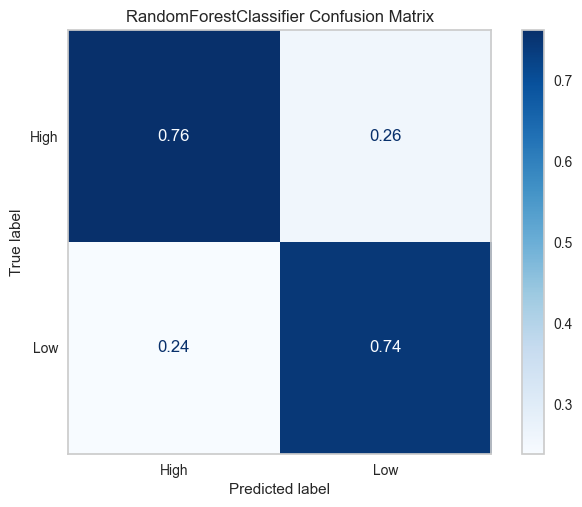

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y,
    y_pred,
    display_labels=classes,
    normalize="pred",
    cmap="Blues",
)

plt.grid(False)

plt.title(f"{model.__class__.__name__} Confusion Matrix")

plt.show()



# Iteratively Redo Everything with selected model

In [ ]:
model = xgb.XGBClassifier(
    n_estimators=study.best_params["n_estimators"],
    max_depth=int(study.best_params["max_depth"]),
    learning_rate=study.best_params["learning_rate"],
    subsample=study.best_params["subsample"],
    colsample_bytree=study.best_params["colsample_bytree"],
    random_state=42,
)


cv = model_selection.KFold(n_splits=20, shuffle=True, random_state=42)

for direction in ["forward", "backward"]:
    print("Direction:", direction)
    print()
    sfs = SequentialFeatureSelector(
        model, n_features_to_select="auto", direction=direction, cv=cv
    )
    sfs.fit(X, y)
    print(X.columns[sfs.get_support()])
    print("-" * 10)

KeyError: 'learning_rate'

In [ ]:
# Drop the features that are not selected at least half of the times

# Comment this line to keep all features
# %%script false --no-raise-error

X_selected = X.drop(
    columns=[
        "cso_sea",
        "cso_hinterland",
        "cso_middle",
    ]
)

In [ ]:
from sklearn import model_selection


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
    max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
    )

    cv = model_selection.KFold(n_splits=20, shuffle=True, random_state=42)
    results = model_selection.cross_val_score(
        estimator=model, X=X, y=y, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [ ]:
study = optuna.create_study(
    direction="maximize",
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-04 17:44:02,988] A new study created in memory with name: no-name-0f24347e-248e-4d84-b62d-d2b5b99f6840


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-04 17:44:08,441] Trial 0 finished with value: 0.6395339745823492 and parameters: {'n_estimators': 860, 'max_depth': 17.937092572013466, 'learning_rate': 0.017379433248035595, 'subsample': 0.12450465263840199, 'colsample_bytree': 0.38137139245066753}. Best is trial 0 with value: 0.6395339745823492.
[I 2024-03-04 17:44:13,340] Trial 1 finished with value: 0.6462843623524739 and parameters: {'n_estimators': 320, 'max_depth': 40.64523471043689, 'learning_rate': 0.011433035601474616, 'subsample': 0.7933215764194306, 'colsample_bytree': 0.5763198683089524}. Best is trial 1 with value: 0.6462843623524739.
[I 2024-03-04 17:44:16,078] Trial 2 finished with value: 0.6567810620751798 and parameters: {'n_estimators': 260, 'max_depth': 20.601779291096996, 'learning_rate': 0.0534655982653228, 'subsample': 0.4416828007001221, 'colsample_bytree': 0.9075530818378332}. Best is trial 2 with value: 0.6567810620751798.
[I 2024-03-04 17:44:19,192] Trial 3 finished with value: 0.6668745809573984 a

KeyboardInterrupt: 